### Loading dataset from CICDDoS2019 and balancing it. Plus, Scaling data points and splitting data

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

df = pd.read_csv("CICDDoS2019_Syn.csv")
df.columns=df.columns.str.strip()

#using the selected features
selectedFeatures=['Destination Port', 'Total Length of Bwd Packets','Bwd Packet Length Std', 'Flow IAT Mean', 'Bwd Packets/s','Packet Length Mean', 'Label']
df=df[selectedFeatures]

# Create a RandomUnderSampler object
under_sampler = RandomUnderSampler(sampling_strategy={'Syn': 35790}, random_state=42)

# Split the features (X) and the target (y)
X = df.drop('Label', axis=1)  # Replace with your actual feature columns
y = df['Label']

# Perform undersampling
X_resampled, y_resampled = under_sampler.fit_resample(X, y)

# Combine the resampled features and labels back into a DataFrame
df = pd.DataFrame(X_resampled, columns=X.columns)
df['Label'] = y_resampled
# Now df_resampled contains a balanced dataset

df["Label"].replace(["BENIGN","Syn"],[0,1],inplace=True)

X = MinMaxScaler().fit_transform(df.drop(['Label'],axis=1))
y=df["Label"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=42,stratify=y)

C:\Users\dyari\AppData\Local\Temp\ipykernel_17472\2799009208.py:8: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("CICDDoS2019_Syn.csv")
C:\Users\dyari\AppData\Local\Temp\ipykernel_17472\2799009208.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Label"].replace(["BENIGN","Syn"],[0,1],inplace=True)
C:\Users\dyari\AppData\Local\Temp\ipykernel_17472\2799009208.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed 

### Training the MLP model

In [30]:
from sklearn.neural_network import MLPClassifier
import time

clf = MLPClassifier(hidden_layer_sizes=(100,200,250),
                    max_iter=100,solver="adam",
                    verbose=True,activation='relu',
                    learning_rate_init=0.01,random_state=42)

start_time = time.time()
# Fit data onto the model
clf.fit(X_train,y_train)

end_time = time.time()
elapsed_time = end_time - start_time

Iteration 1, loss = 0.26064150
Iteration 2, loss = 0.22385367
Iteration 3, loss = 0.21848758
Iteration 4, loss = 0.21679699
Iteration 5, loss = 0.21161189
Iteration 6, loss = 0.20856556
Iteration 7, loss = 0.21628192
Iteration 8, loss = 0.21178082
Iteration 9, loss = 0.20559408
Iteration 10, loss = 0.20512327
Iteration 11, loss = 0.19386685
Iteration 12, loss = 0.21235755
Iteration 13, loss = 0.21117740
Iteration 14, loss = 0.20110180
Iteration 15, loss = 0.19154646
Iteration 16, loss = 0.16130957
Iteration 17, loss = 0.13017890
Iteration 18, loss = 0.12782189
Iteration 19, loss = 0.12769762
Iteration 20, loss = 0.12569670
Iteration 21, loss = 0.12631286
Iteration 22, loss = 0.12109771
Iteration 23, loss = 0.12347112
Iteration 24, loss = 0.11991080
Iteration 25, loss = 0.13010807
Iteration 26, loss = 0.12113639
Iteration 27, loss = 0.12255642
Iteration 28, loss = 0.12149562
Iteration 29, loss = 0.12430125
Iteration 30, loss = 0.12161071
Iteration 31, loss = 0.11963022
Iteration 32, los

### Predictions BEFORE sample modification

Accuracy: 0.938041352333054
---------------------------------------------------------


array([[6905,  253],
       [ 634, 6524]], dtype=int64)

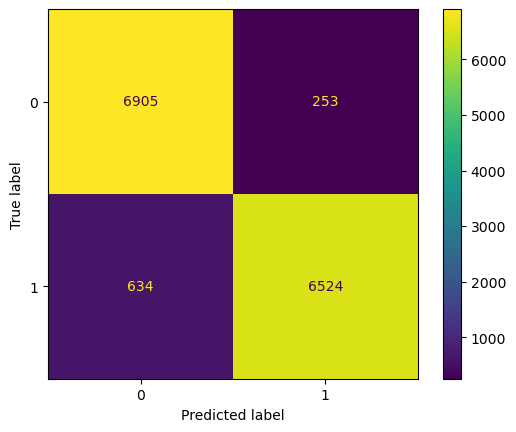

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score

y_pred=clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test,y_pred))
print("---------------------------------------------------------")

BeforePerturbation = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
BeforePerturbation.confusion_matrix

### Sample modification - Both Benign and Malicious Shuffle

In [34]:
import random

#Identify the unique 'Flow IAT Mean' values of all classes
unique_values = df['Flow IAT Mean'].unique()

random.seed(42)

def SystematicShuffling(X, y, feature='Flow IAT Mean'):
    # Ensure X and y are pandas DataFrames and Series
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=df.drop(columns=['Label']).columns)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)

    X_copy = X.copy()
    y_copy = y.copy()

    # Loop through the dataset
    for idx in range(len(X)):
        X_copy.loc[idx, feature] = random.choice(unique_values)

    return X_copy, y_copy


X_evasive3, y_evasive3 = SystematicShuffling(X_test, y_test, feature='Flow IAT Mean')

### Predictions After sample modification - Both Benign and Malicious Shuffle

C:\Users\dyari\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.5016764459346186
---------------------------------------------------------


array([[7140,   18],
       [7116,   42]], dtype=int64)

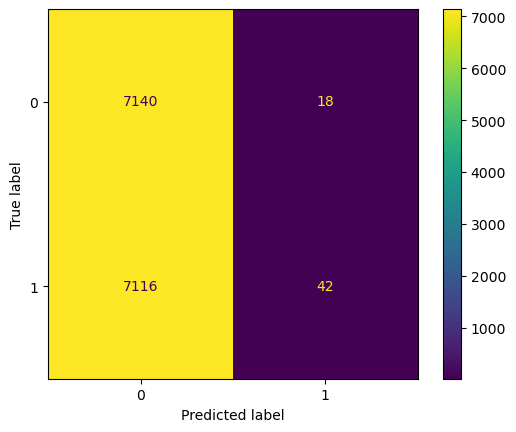

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score

y_pred3_evasive = clf.predict(X_evasive3)

print("Accuracy:", accuracy_score(y_evasive3,y_pred3_evasive))
print("---------------------------------------------------------")


Perturb03=ConfusionMatrixDisplay.from_predictions(y_evasive3, y_pred3_evasive)
Perturb03.confusion_matrix